In [101]:
import torch.utils.data as data
from PIL import Image
import os
import os.path
import torch
import numpy as np
import torchvision.transforms as transforms
import argparse
import time
import random
import numpy.ma as ma
import copy
import scipy.misc
import scipy.io as scio
from lib.proj_utils import *
from lib.transformations import translation_matrix, quaternion_matrix, quaternion_from_matrix
import quaternion as qua
from so3_data import *

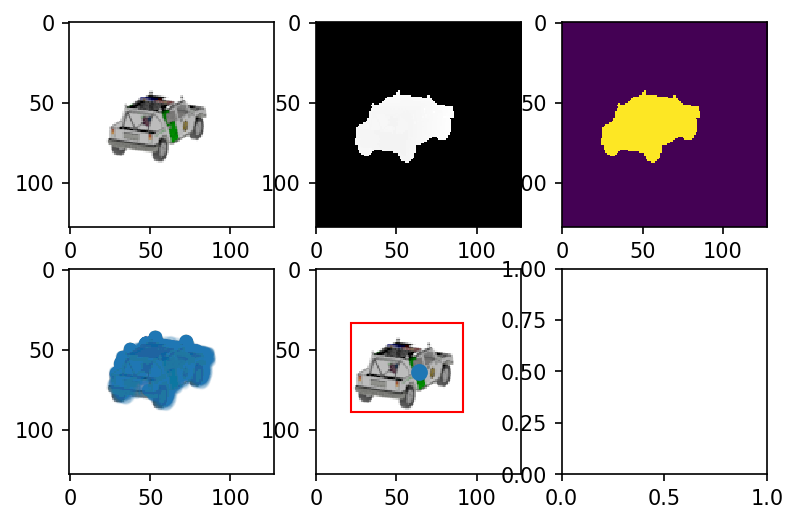

In [102]:
cat = "car"
data_dir = "/hdd/zen/dev/6dof/6dof_data/"
model_index = "0001"
index = 0
cld = read_pointxyz( os.path.join(data_dir, cat +"_ycb", "models"))
value, boxes, img_color, depth_img, semantic = diplay_gen_ycb(cat, data_dir, cld, model_index, index)

In [103]:
import matplotlib.pyplot as plt
dataset_root = "/hdd/zen/dev/6dof/6dof_data/car_ycb"
transform=transforms.Compose([transforms.ToTensor()])
train_dataset = PoseDataset('train', dataset_root, transforms=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)

test_dataset = PoseDataset('test', dataset_root, transforms=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)


# ## Data inspection 
# for i, data in enumerate(train_loader, 0):
#     img, depth, boxes, label, pose_r, pose_t,  cam,idx= data
#     for i in range(img.shape[0]):
# #     for i in range(1):
#         display_load_img(img[i], depth[i], boxes[i][0], label[i], cam[i], pose_t[i], pose_r[i], dataset.models[idx[i]])
#         print("------------------------------------------------------------------------------------------")
#         break
#     break

# Data Training loop 
for i, data in enumerate(train_loader, 0):
    img, depth, boxes, label, pose_r, pose_t,  cam,idx= data
    print(pose_r.shape)
    quat = quaternion_from_matrix(pose_r)
    break
    


400
100
torch.Size([8, 4])


In [104]:
import quaternion as qua
qua.from_rotation_matrix(pose_r)

quaternion(0.642956057093082, 0.0919537558328988, 0.640750691123455, 0.4093782691599)